In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nlooucgj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nlooucgj
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
HOME = "/content/drive/MyDrive/Projects/SAM_results"

In [ ]:
import torch
import torchvision
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join as pjoin
from sklearn.cluster import KMeans
import numpy.linalg as npLA

In [ ]:
os.chdir(HOME)

In [ ]:
def convert_bbox_xywh2xyxy(bbox_xywh):
    x1, y1, w, h = bbox_xywh
    x2 = x1 + w
    y2 = y1 + h
    bbox_xyxy = (x1, y1, x2, y2)

    return bbox_xyxy

def convert_bbox_xyxy2xywh(bbox_xyxy):
    x1, y1, x2, y2 = bbox_xyxy
    w = x2 - x1
    h = y2 - y1
    bbox_xywh = (x1, y1, w, h)

    return bbox_xywh

def load_image(image_path):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    return np.uint8(image)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def display_masked_image(image, x1, y1, x2, y2, dtype=np.int32, figsize=(5, 5)):
    h, w, c = image.shape
    masked_image = np.zeros((h, w, c), dtype=dtype)
    masked_image[y1:y2, x1:x2, :] = image[y1:y2, x1:x2, :]

    plt.figure(figsize=figsize)
    plt.imshow(masked_image)
    plt.axis('on')
    plt.show()

def morph_indexes(x1, y1, x2, y2, Yi, Xi, Yf, Xf):
    X1 = int(((Xf - 0)*(x1 - 0)) /(Xi - 0) + 0)
    X2 = int(((Xf - 0)*(x2 - 0)) /(Xi - 0) + 0)
    Y1 = int(((Yf - 0)*(y1 - 0)) /(Yi - 0) + 0)
    Y2 = int(((Yf - 0)*(y2 - 0)) /(Yi - 0) + 0)

    return (X1, Y1, X2, Y2)

In [ ]:
import sys
sys.path.append("..")
# sys.path.append(HOME)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

SAM_CHECKPOINT = pjoin(HOME, "sam_vit_h_4b8939.pth")
SAM_MODEL_TYPE = "vit_h"
SAM_DEVICE = "cuda"

In [ ]:
class SAM:

    def __init__(self, model_checkpoint=SAM_CHECKPOINT, model_type=SAM_MODEL_TYPE, model_device=SAM_DEVICE):
        sam = sam_model_registry[model_type](checkpoint=model_checkpoint)
        sam.to(device=model_device)

        self._mask_generator = SamAutomaticMaskGenerator(sam)
        self._predictor = SamPredictor(sam)

    def test(self):
        print(f"__dict__ = {self.__dict__.keys()}")
        print(f"dir() = {dir(self)}")
        pass

    def get_anns(self, image):
        anns_ld = self._mask_generator.generate(image)
        anns_ld = sorted(anns_ld, key=(lambda x: x['area']), reverse=True)

        return anns_ld

    def get_image_embedds(self, image):
        self._predictor.set_image(image)
        embedds = self._predictor.get_image_embedding()

        return embedds

    def get_mask_embedds(self, embedds, mask):
        x1, y1, x2, y2 = mask
        masked_embedds = embedds[:, :, y1:y2, x1:x2]
        gap2d_layer = torch.nn.AdaptiveAvgPool2d((1,1))
        masked_embedds = gap2d_layer(masked_embedds)
        return torch.squeeze(masked_embedds)

    def get_segment_embedds(self, image):
        assert image.shape[0] == image.shape[1]

        img_anns_ld = self.get_anns(image)
        img_embedds = self.get_image_embedds(image)

        infos = []
        for ann in img_anns_ld:
            bbox_xywh = ann["bbox"]
            bbox = convert_bbox_xywh2xyxy(bbox_xywh)
            hi, wi, _ = image.shape
            _, _, hf, wf = img_embedds.shape
            new_bbox = morph_indexes(*bbox, *(hi, wi), *(hf, wf))
            embedd = self.get_mask_embedds(img_embedds, new_bbox)

            info = {
                "segment" : ann["segmentation"],
                "bbox_xywh" : bbox_xywh,
                "area" : ann["area"],
                "img_shape" : image.shape[:-1],
                "segment_embedd" : embedd
            }

            infos.append(info)

        return infos, img_anns_ld, img_embedds

# Demo

## Inference

In [ ]:
sam_module = SAM()
print(sam_module)

In [ ]:
mb_dict = torch.load(pjoin("memory_bank", "mb51_bdd100k.pt"), map_location=torch.device("cpu"))
mb, mipc, mb_classes = mb_dict["memory_bank"], mb_dict["mipc"], mb_dict["classes"]

print(mb.shape)
print(mipc)
print(mb_classes)

torch.Size([510, 256])
51
['car', 'truck', 'person', 'bus', 'train', 'traffic sign', 'motor', 'traffic light', 'rider', 'bike']


In [ ]:
nClasses = int(mb.shape[0]/mipc)
print(nClasses)

10


(1418, 1000, 3)
(500, 500, 3)


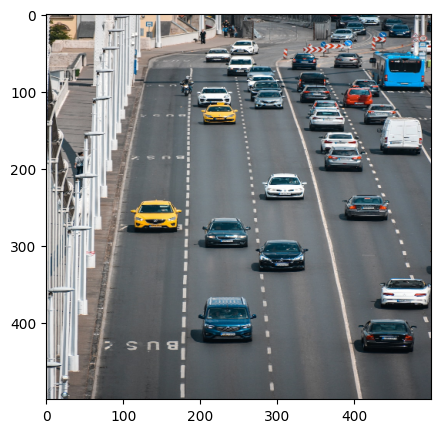

In [ ]:
image = load_image(pjoin("assets", "cars_on_highway.jpeg"))
print(image.shape)

resize = (500, 500)

image = cv2.resize(image, resize)
print(image.shape)


plt.figure(figsize=(5,5))
plt.imshow(image)
plt.show()

In [ ]:
se_infos, anns, img_embedds = sam_module.get_segment_embedds(image)

In [ ]:
cos_sim = torch.nn.CosineSimilarity(dim=1)
thres = 0.8

infos = []

for se_info in se_infos:
    em  = se_info["segment_embedd"]
    sim_map = cos_sim(em.detach().cpu(), mb)
    thres_map = (sim_map > thres)
    cls = None
    max_sim_score = 0
    avg_sim_score = 0
    for i in range(nClasses):
        cls_thres_map = thres_map[(i)*mipc: (i+1)*mipc]
        cls_sim_map = sim_map[(i)*mipc: (i+1)*mipc]
        freq = torch.count_nonzero(cls_thres_map)
        cls_sim_scores = cls_sim_map[(cls_thres_map)]

        if freq != 0:
            max_cls_score = cls_sim_scores.max()
            avg_cls_score = cls_sim_scores.mean()

            if max_cls_score > max_sim_score or (max_cls_score == max_sim_score and avg_cls_score > avg_sim_score):
                max_sim_score = max_cls_score
                avg_sim_score = avg_cls_score
                cls = [i]
            elif max_cls_score == max_sim_score and avg_sim_score == avg_cls_score:
                cls.append(i)
    print(cls)
    info = se_info
    info["class"] = cls
    infos.append(info)

[4]
[0]
[0]
[3]
[5]
[4]
[0]
[0]
[9]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[4]
[7]
[2]
[3]
[7]
[7]
[9]
None
None
None
None
None
[7]
[4]
None
None
[1]
[4]
[5]
None
None
[3]
None
None
[4]
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
[8]
None
None
None
None
None
None
None
None
None
None
None
None
None
[7]
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [ ]:
masks = torch.zeros((nClasses, *resize), dtype=torch.uint8)
for info in infos:
  seg = torch.from_numpy(info["segment"])
  cls = info["class"]

  if cls == None:
    continue

  for i in cls:
    masks[i] = torch.logical_or(masks[i], seg)

## Qualitative Result

In [ ]:
color_palette = [
    [204, 70, 3],
    [255, 173, 0],
    [235, 255, 7],
    [255, 0, 255],
    [0, 100, 128],# 192
    [0, 255, 204],
    [70, 184, 160],#[0, 128, 0],
    [0, 255, 61],
    [128, 128, 64],#
    [255, 0, 122]#[128, 128, 64]
]
MBCLS2CP = dict(zip(mb_classes, color_palette))

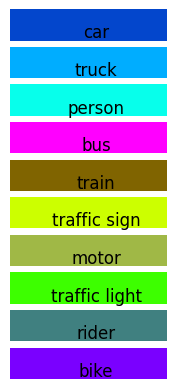

In [ ]:
fig, ax = plt.subplots(10, 1)

for i in range(len(mb_classes)):

  temp = torch.zeros((2, 10,3), dtype=torch.uint8)
  temp[:,:] = torch.from_numpy(np.array(MBCLS2CP[mb_classes[i]], dtype=np.uint8))

  ax[i].imshow(cv2.cvtColor(temp.detach().numpy(),cv2.COLOR_BGR2RGB))
  ax[i].text(x=5, y=1, s=f"{mb_classes[i]}", va='center', ha='center', size='large')
  ax[i].set_axis_off()

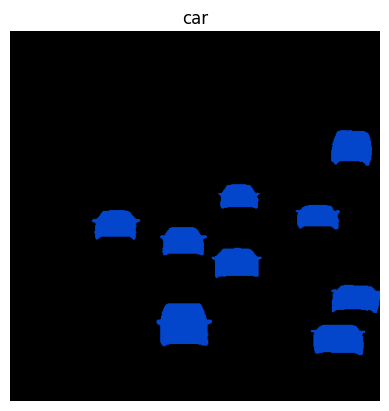

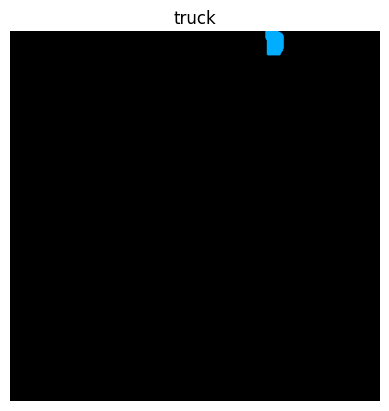

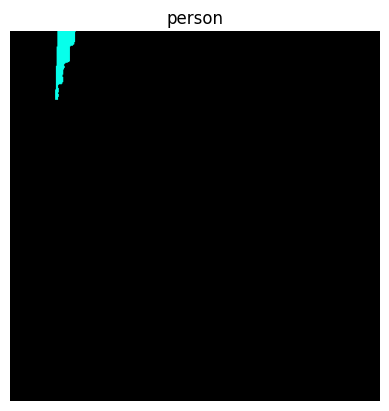

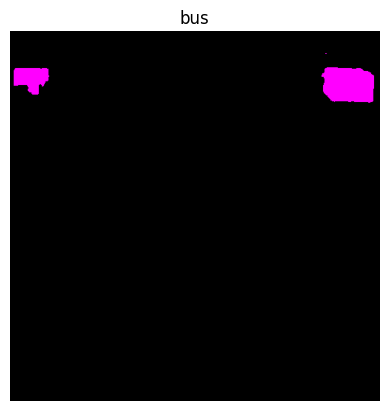

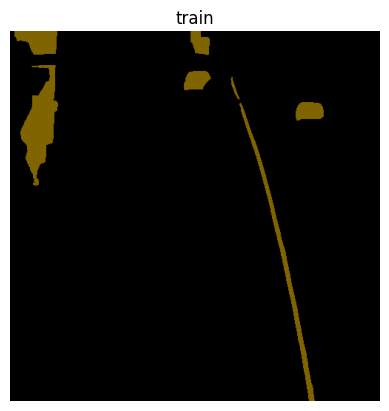

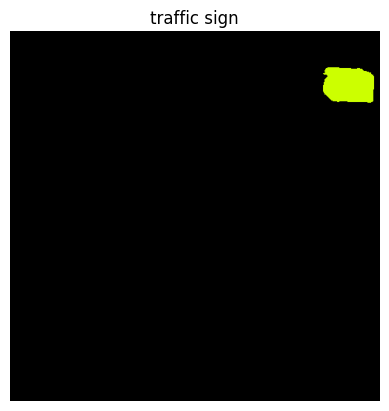

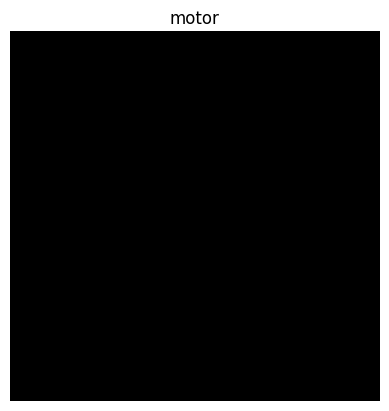

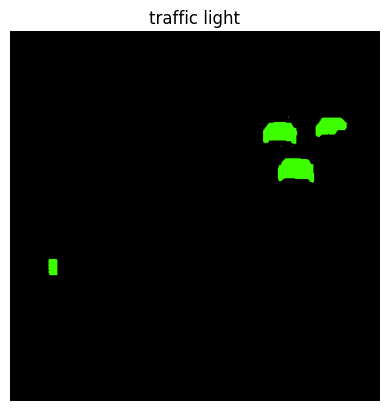

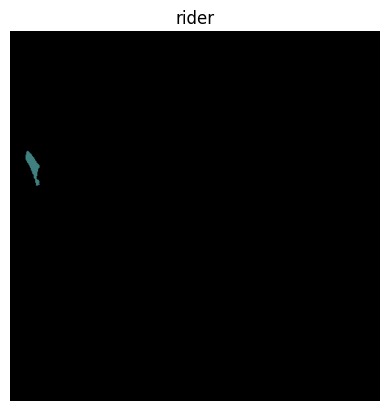

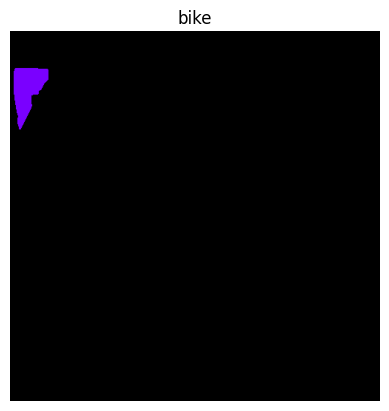

In [ ]:
cseg_image = torch.zeros((masks.shape[1],masks.shape[2], 3), dtype=torch.uint8)

for i in range(nClasses):
  c = MBCLS2CP[mb_classes[i]]
  temp_img = torch.zeros_like(cseg_image)
  cls_mask = masks[i, :, :]
  idx = cls_mask > 0
  cseg_image[idx] = torch.from_numpy(np.array(c, dtype=np.uint8))
  temp_img[idx] = torch.from_numpy(np.array(c, dtype=np.uint8))
  # print(i, mb_classes[i])
  plt.imshow(cv2.cvtColor(temp_img.detach().numpy(), cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title(f"{mb_classes[i]}")
  plt.show()
  print()

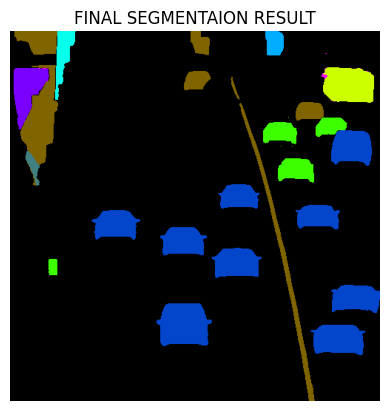

In [ ]:
plt.imshow(cv2.cvtColor(cseg_image.detach().numpy(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"FINAL SEGMENTAION RESULT")
plt.show()